In [139]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('mode.chained_assignment', None)

# from pandas.core.common import SettingWithCopyWarning

# from pandas.core.common import 

# import warnings
# warnings.filterwarnings('ignore', category=SettingWithCopyWarning)

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_regression

from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import DBSCAN

from sklearn.mixture import GaussianMixture

from sklearn.model_selection import GridSearchCV



Plotowanie granic decyzyjnych

In [140]:
def plot_decision_boundaries(klasyfikator, X):
    # wyznaczanie granic decyzyjnych, podobnie jak w poprzednich notatnikach
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 100),
                         np.linspace(mins[1], maxs[1], 100))
    Z = klasyfikator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # rysowanie konturów granic 
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    
    # rysowanie danych
    plt.scatter(X[:, 0], X[:, 1], c='k', s=2, alpha=0.1)
    # centra klastrów można wyciągnąc za pomocą zmiennej cluster_centers_
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

Wczytanie danych i połączenie w jeden DataFrame

In [141]:
train = pd.read_fwf('samsung_train.txt', header=None)
test = pd.read_fwf('samsung_test.txt', header=None)
train_labels = pd.read_fwf('samsung_train_labels.txt', header=None)
test_labels = pd.read_fwf('samsung_test_labels.txt', header=None)
features = pd.read_fwf('features.txt', header=None, sep="").values
features = list(features.flatten())
features = [i.split(" ")[-1] for i in features]
data_raw = pd.concat([train, test], axis=0)
labels_raw = pd.concat([train_labels, test_labels], axis=0)-1
data_raw.columns=features

data_raw.head()


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFre,fBodyBodyGyroJerkMag-skewnes,fBodyBodyGyroJerkMag-kurtosi,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),grav","angle(tBodyGyroMean,gravityM","angle(tBodyGyroJerkMean,grav","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


Usunięcie częsci zmiennych - pozostawiam tylko te związane ze spektrum częstotliwości (akcelerometr przy ciele)

In [142]:
features_to_remove = []

for feature in features:
    if "Gravity" in feature\
        or "Gyro" in feature\
            or "angle" in feature\
                or "tBody" in feature\
                    or "bandsEnergy" in feature:
        features_to_remove.append(feature)
        
print(f'{len(features_to_remove) = }')
features = list(set(features)-set(features_to_remove))
print(f'{len(features) = }')


len(features_to_remove) = 461
len(features) = 100


In [143]:
data_raw.drop(features_to_remove, axis=1, inplace=True)

In [144]:
data_raw.corr()

,fBodyAcc-mean()-X,fBodyAcc-mean()-Y,fBodyAcc-mean()-Z,fBodyAcc-std()-X,fBodyAcc-std()-Y,fBodyAcc-std()-Z,fBodyAcc-mad()-X,fBodyAcc-mad()-Y,fBodyAcc-mad()-Z,fBodyAcc-max()-X,...,fBodyBodyAccJerkMag-max(),fBodyBodyAccJerkMag-min(),fBodyBodyAccJerkMag-sma(),fBodyBodyAccJerkMag-energy(),fBodyBodyAccJerkMag-iqr(),fBodyBodyAccJerkMag-entropy(,fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq,fBodyBodyAccJerkMag-skewness,fBodyBodyAccJerkMag-kurtosis
fBodyAcc-mean()-X,1.000000,0.944602,0.905912,0.978571,0.913493,0.836359,0.994113,0.936745,0.886599,0.936960,...,0.916611,0.760753,0.974830,0.895787,0.964200,0.961259,-0.043432,-0.424206,0.473646,0.422716
fBodyAcc-mean()-Y,0.944602,1.000000,0.903791,0.923478,0.978787,0.851799,0.939545,0.993250,0.890077,0.886443,...,0.909448,0.744484,0.956814,0.860085,0.941850,0.963151,-0.056093,-0.440528,0.514955,0.465640
fBodyAcc-mean()-Z,0.905912,0.903791,1.000000,0.882975,0.890293,0.950814,0.901753,0.900760,0.989859,0.845845,...,0.883895,0.725983,0.923067,0.839827,0.908305,0.925676,-0.057673,-0.422816,0.509537,0.465310
fBodyAcc-std()-X,0.978571,0.923478,0.882975,1.000000,0.905050,0.829520,0.985832,0.919933,0.869363,0.983371,...,0.900286,0.736071,0.942725,0.854387,0.936033,0.940714,-0.039816,-0.418208,0.489684,0.448582
fBodyAcc-std()-Y,0.913493,0.978787,0.890293,0.905050,1.000000,0.872318,0.912803,0.988791,0.889518,0.877717,...,0.869007,0.709425,0.915482,0.798357,0.905006,0.944050,-0.061920,-0.450140,0.516518,0.469750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fBodyBodyAccJerkMag-entropy(,0.961259,0.963151,0.925676,0.940714,0.944050,0.882162,0.957717,0.958807,0.917035,0.901843,...,0.921160,0.740976,0.966040,0.846017,0.955957,1.000000,-0.075562,-0.503252,0.552833,0.493251
fBodyBodyAccJerkMag-maxInds,-0.043432,-0.056093,-0.057673,-0.039816,-0.061920,-0.069292,-0.042882,-0.058007,-0.061013,-0.036501,...,-0.058602,-0.032585,-0.046717,-0.028198,-0.043101,-0.075562,1.000000,0.304796,-0.259331,-0.197655
fBodyBodyAccJerkMag-meanFreq,-0.424206,-0.440528,-0.422816,-0.418208,-0.450140,-0.429901,-0.434132,-0.447846,-0.431391,-0.386927,...,-0.420214,-0.260843,-0.409964,-0.338753,-0.425336,-0.503252,0.304796,1.000000,-0.522413,-0.395773
fBodyBodyAccJerkMag-skewness,0.473646,0.514955,0.509537,0.489684,0.516518,0.500693,0.476133,0.515773,0.507665,0.502902,...,0.652649,0.406601,0.499372,0.445347,0.458427,0.552833,-0.259331,-0.522413,1.000000,0.973284


In [145]:
description = data_raw.describe()
description

,fBodyAcc-mean()-X,fBodyAcc-mean()-Y,fBodyAcc-mean()-Z,fBodyAcc-std()-X,fBodyAcc-std()-Y,fBodyAcc-std()-Z,fBodyAcc-mad()-X,fBodyAcc-mad()-Y,fBodyAcc-mad()-Z,fBodyAcc-max()-X,...,fBodyBodyAccJerkMag-max(),fBodyBodyAccJerkMag-min(),fBodyBodyAccJerkMag-sma(),fBodyBodyAccJerkMag-energy(),fBodyBodyAccJerkMag-iqr(),fBodyBodyAccJerkMag-entropy(,fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq,fBodyBodyAccJerkMag-skewness,fBodyBodyAccJerkMag-kurtosis
count,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,...,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000
mean,-0.622762,-0.537493,-0.665034,-0.603356,-0.528420,-0.617875,-0.590772,-0.522201,-0.632333,-0.651544,...,-0.682696,-0.803308,-0.620790,-0.840996,-0.676629,-0.338469,-0.877800,0.173220,-0.298598,-0.601659
std,0.420795,0.481682,0.358853,0.446793,0.479925,0.398973,0.457338,0.496561,0.389522,0.405419,...,0.369694,0.269888,0.425064,0.228000,0.365550,0.666857,0.189655,0.252537,0.364723,0.353928
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.991256,-0.979218,-0.983227,-0.992917,-0.976887,-0.977977,-0.991649,-0.980107,-0.980921,-0.994312,...,-0.992488,-0.986824,-0.989784,-0.999851,-0.988546,-1.000000,-0.968254,-0.002959,-0.601439,-0.878842
50%,-0.945579,-0.864345,-0.895354,-0.941575,-0.832613,-0.839787,-0.944202,-0.857111,-0.878010,-0.943425,...,-0.935444,-0.959680,-0.928987,-0.996683,-0.942217,-0.682105,-0.904762,0.164180,-0.347522,-0.713718
75%,-0.264555,-0.103228,-0.366240,-0.249345,-0.092156,-0.302252,-0.202587,-0.078901,-0.305610,-0.351577,...,-0.404254,-0.678599,-0.259970,-0.730491,-0.371697,0.346184,-0.873016,0.357307,-0.057690,-0.425813
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Wciaż bardzo dużo danych, trudno cokolwiek powiedzieć

<AxesSubplot: >

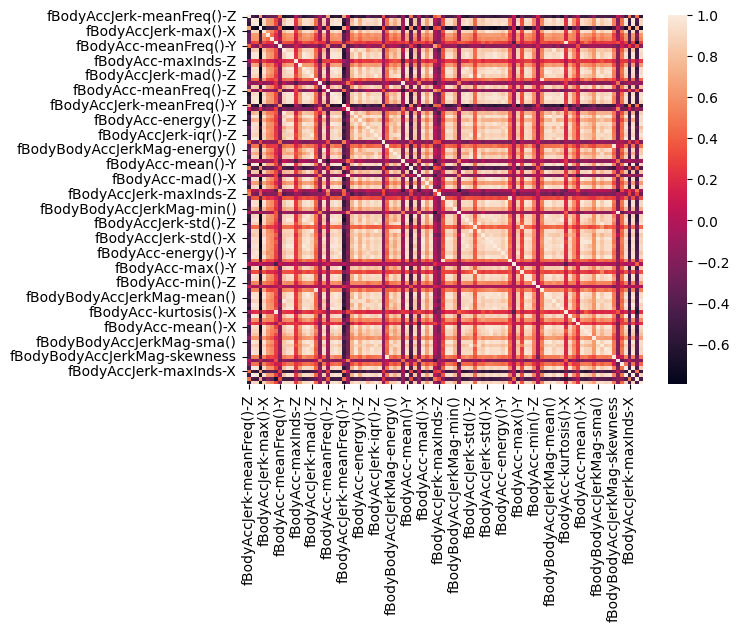

In [146]:
sns.heatmap(data_raw[features].corr())

## Clustering - Unsupervised Learning

### Próba wizualizacji dla wybranych dwóch zmiennych

Dla celów wizualizacji wybiorę tylko dwie zmienne

true = [4 4 4 ... 1 1 1], pred = [2 2 2 ... 1 1 1]
f1_score: 0.37085609108457096


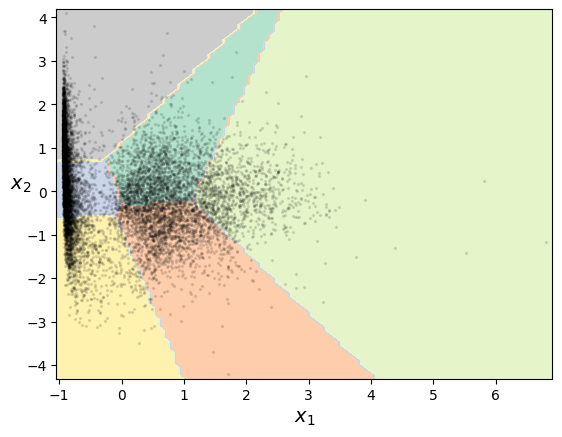

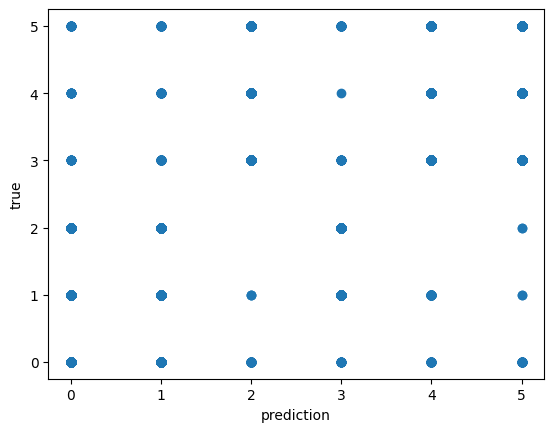

In [147]:
data = data_raw[['fBodyAccMag-max()', 'fBodyAcc-meanFreq()-Y']]
scaler = StandardScaler()
data['labels'] = labels_raw
X = data[['fBodyAccMag-max()', 'fBodyAcc-meanFreq()-Y']]
X = scaler.fit_transform(X)
clf = KMeans(n_clusters=6, n_init='auto', max_iter=50000, random_state=2)
clf.fit(X)
y_pred = clf.predict(X)
plot_decision_boundaries(clf, X)

y_true = labels_raw
print(f'true = {y_true.values.flatten()}, pred = {y_pred}')

F_1 = f1_score(y_true, y_pred, average='weighted')
print(f'f1_score: {F_1}')

plt.figure()
plt.scatter(y_pred, y_true)
plt.xlabel('prediction')
plt.ylabel('true')
plt.show()

Wyniki wychodzą od Sasa do Lasa.

### KFold

Bez użycia KFold

In [148]:
X = data_raw.copy().values
y = labels_raw.copy().values.ravel()

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [150]:
clf = SGDClassifier()

clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print("Pojedynczy wynik: ", score)

Pojedynczy wynik:  0.7744336569579288


In [151]:
X.shape

(10299, 100)

Z KFold

In [152]:
# stworzenie KFold obiektu z 5 foldami i tasowaniem danych
kf = KFold(n_splits=5, shuffle=True, random_state=1)

models = []
scores = []

# iteracja przez poszczególne foldy
for fold_nr, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train = X[train_idx]
    X_test =X[test_idx]

    y_train = y[train_idx]
    y_test = y[test_idx]

    # skalowanie danych wewnątrz poszczeŋólnych iteracji
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
  
    # stworzenie klasyfikatora dla poszczególnej iteracji
    # wytrenowanie klasyfikatora na danych treningowych
    clf = SGDClassifier(random_state=1).fit(X_train, y_train)

    # dodawanie klasyfikatora do tablicy klasyfikatorów
    models.append(clf)
    # dodawanie wyniku dla danych testowych do tablicy
    scores.append(clf.score(X_test, y_test))

print("wyniki poszczególnych foldów: ", scores)
print("sredni wynik wszystkich foldów: ", np.array(scores).mean())

wyniki poszczególnych foldów:  [0.7689320388349514, 0.7815533980582524, 0.7762135922330097, 0.7747572815533981, 0.7663914521612433]
sredni wynik wszystkich foldów:  0.773569552568171


Jest nieco lepiej

In [153]:
from sklearn.model_selection import cross_val_score, cross_val_predict

# stworzenie klasyfikatora
clf = SGDClassifier(random_state=1)

# uzycie metory cross_val_Score do sprawdzenia działania naszego modelu na róznych podziałach
cv_score = cross_val_score(clf, X, y, cv=5)
print("wynik kroswalidacji: ", cv_score)
print("średni wynik wszystkich foldów: ", cv_score.mean())

wynik kroswalidacji:  [0.73980583 0.70291262 0.75873786 0.79320388 0.75619233]
średni wynik wszystkich foldów:  0.7501705041093565


In [154]:
#Przykład podziału za pomocą stratyfikacji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=3, stratify=y)
# summarize
train_0, train_1, train_2, train_3, train_4, train_5 = len(y_train[y_train==0]), len(y_train[y_train==1]), len(y_train[y_train==2]), len(y_train[y_train==3]), len(y_train[y_train==4]), len(y_train[y_train==5])
test_0, test_1, test_2, test_3, test_4, test_5 =  len(y_test[y_test==0]), len(y_test[y_test==1]), len(y_test[y_test==2]), len(y_test[y_test==3]), len(y_test[y_test==4]), len(y_test[y_test==5])
print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
print('>Train: 2=%d, 3=%d, Test: 2=%d, 3=%d' % (train_2, train_3, test_2, test_3))

>Train: 0=1378, 1=1235, Test: 0=344, 1=309
>Train: 2=1125, 3=1421, Test: 2=281, 3=356


In [155]:
# wcześniejszy przykład z użyciem stratifiedKFold

from sklearn.model_selection import StratifiedKFold


# stworzenie KFold obiektu z 5 foldami i tasowaniem danych
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

models = []
scores = []

# iteracja przez poszczególne foldy
for fold_nr, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train = X[train_idx]
    X_test =X[test_idx]

    y_train = y[train_idx]
    y_test = y[test_idx]

    # skalowanie danych wewnątrz poszczeŋólnych iteracji
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
  
    # stworzenie klasyfikatora dla poszczególnej iteracji
    # wytrenowanie klasyfikatora na danych treningowych
    clf = SGDClassifier(random_state=1).fit(X_train, y_train)

    # dodawanie klasyfikatora do tablicy klasyfikatorów
    models.append(clf)
    # dodawanie wyniku dla danych testowych do tablicy
    scores.append(clf.score(X_test, y_test))


print("wyniki poszczególnych foldów: ", scores)
print("średni wynik wszystkich foldów: ", np.array(scores).mean())

wyniki poszczególnych foldów:  [0.7902912621359224, 0.7694174757281553, 0.787864077669903, 0.7834951456310679, 0.7731908693540553]
średni wynik wszystkich foldów:  0.7808517661038208


Znowu (nieco) lepiej.

### Clustering

In [156]:
X = data_raw.copy().values
y = labels_raw.copy().values.ravel()
X

array([[-0.99478319, -0.9829841 , -0.93926865, ...,  0.34698853,
        -0.51608015, -0.80276003],
       [-0.99745072, -0.97685173, -0.97352267, ...,  0.53206052,
        -0.62487099, -0.90015998],
       [-0.99359409, -0.97251146, -0.98330396, ...,  0.66079504,
        -0.72469672, -0.92853938],
       ...,
       [-0.3626403 , -0.1868022 , -0.27113781, ...,  0.11166906,
         0.18227833, -0.09585943],
       [-0.37836537, -0.40006993, -0.28232007, ..., -0.02203329,
         0.04992661, -0.31112802],
       [-0.40122263, -0.31841507, -0.22212296, ...,  0.13625728,
        -0.05451484, -0.40429684]])

In [157]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

#### KMeans

basic

In [158]:
clf = KMeans(n_clusters=6, n_init='auto')
y_pred = clf.fit_predict(X)
print(y_pred)
print(y_true.values.ravel())

[0 5 0 ... 3 2 2]
[4 4 4 ... 1 1 1]


minibatch

In [159]:
mb_clf = MiniBatchKMeans(n_clusters=6, n_init='auto')
y_pred = mb_clf.fit_predict(X)
print(y_pred)
print(y_true.values.ravel())

[5 5 5 ... 0 0 0]
[4 4 4 ... 1 1 1]


Dobieranie najlepszej liczby K

In [160]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X)
                for k in range(1, 10)]

In [161]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

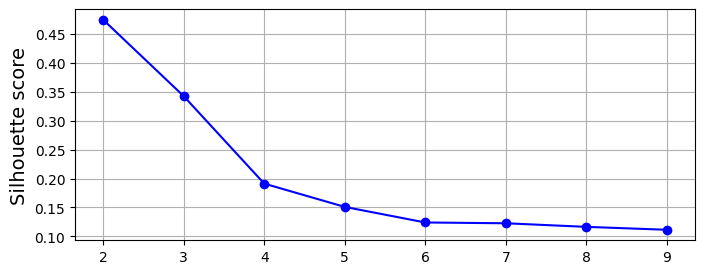

In [162]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.ylabel("Silhouette score", fontsize=14)
plt.grid()
plt.show()

Wygląda na to, że 

#### KMeans jako preprocessor

In [163]:
X = data_raw.copy().values
y = labels_raw.copy().values.ravel()

In [164]:
X = scaler.fit_transform(X)

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, stratify=y)

In [166]:
log_reg = LogisticRegression(multi_class="ovr", max_iter=5000, random_state=2)
log_reg.fit(X_train, y_train)
print("Bez KMeans :", log_reg.score(X_test, y_test))

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=2, n_init='auto')),
    ("log_reg", LogisticRegression(multi_class="ovr", max_iter=5000, random_state=2)),
])
pipeline.fit(X_train, y_train)
print("Z KMeans :", pipeline.score(X_test, y_test))

Bez KMeans : 0.7996116504854369
Z KMeans : 0.7693203883495146


Tu nie jest lepiej

#### DBSCAN

In [167]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.05, min_samples=50)
y_db_pred = dbscan.fit_predict(X)


dbscan_2 = DBSCAN(eps=0.1, min_samples=50)
y_db_2_pred = dbscan_2.fit_predict(X)

In [168]:
dbscan.fit(X).labels_, dbscan_2.fit(X).labels_

(array([-1, -1, -1, ..., -1, -1, -1], dtype=int64),
 array([-1, -1, -1, ..., -1, -1, -1], dtype=int64))

In [169]:
y_db_pred, y_db_2_pred

(array([-1, -1, -1, ..., -1, -1, -1], dtype=int64),
 array([-1, -1, -1, ..., -1, -1, -1], dtype=int64))

DBSCAN zdaje się nie działać kompletnie na tym zbiorze, albo ja nie wiem co robię...

### Gaussian Mixture

In [170]:
gm = GaussianMixture(n_components=6, n_init=10, random_state=42)
gm.fit(X)

y_gm_pred = gm.predict(X)
y_gm_pred, y

(array([3, 1, 1, ..., 5, 2, 2], dtype=int64),
 array([4, 4, 4, ..., 1, 1, 1], dtype=int64))

In [171]:
gm.score(X,y)

141.46312848829146

## Supervised Learning

Z uwagi na to, że komputer nie daje rady na wszystkich 100 cechach, trenuję przykładowo na trzech.

In [187]:
X = data_raw[['fBodyAcc-max()-X', 'fBodyAcc-max()-Y', 'fBodyAcc-max()-Z']].copy().values
y = labels_raw.copy().values.ravel()

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)

### Regresja Logistyczna

In [189]:
pipe_LR = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(degree=3, include_bias=False)),
    ('estimator', LogisticRegression(multi_class='ovr', solver='saga', max_iter=10000, random_state=1)),
])

In [190]:
pipe_LR.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('preprocessor', PolynomialFeatures(degree=3, include_bias=False)),
  ('estimator',
   LogisticRegression(max_iter=10000, multi_class='ovr', random_state=1,
                      solver='saga'))],
 'verbose': False,
 'scaler': StandardScaler(),
 'preprocessor': PolynomialFeatures(degree=3, include_bias=False),
 'estimator': LogisticRegression(max_iter=10000, multi_class='ovr', random_state=1,
                    solver='saga'),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'preprocessor__degree': 3,
 'preprocessor__include_bias': False,
 'preprocessor__interaction_only': False,
 'preprocessor__order': 'C',
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 10000,
 'estimator__multi_class': 'ovr',
 'estimator__n_jobs': None,
 'estimator__pen

In [191]:
params_LR = {
    'preprocessor__degree': [1,2,3,4],
    'estimator__C': [0.01, 0.1, 1, 10, 100]
}

grid_search_LR = GridSearchCV(pipe_LR, params_LR, cv=10, n_jobs=-1, verbose=10, scoring='f1_macro')
grid_search_LR.fit(X_train, y_train)

print('Wybrane hiperparametry: ', grid_search_LR.best_params_)

model_LR = grid_search_LR.best_estimator_

print(f'Score na danych treningowych: {model_LR.score(X_train, y_train): }')
print(f'Score na danych testowych: {model_LR.score(X_test, y_test): }')

Fitting 10 folds for each of 20 candidates, totalling 200 fits


Wybrane hiperparametry:  {'estimator__C': 100, 'preprocessor__degree': 3}
Score na danych treningowych:  0.6704119850187266
Score na danych testowych:  0.6718446601941748


### KNearestNeighbors

In [192]:
pipe_KNN = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(degree=3, include_bias=False)),
    ('estimator', KNeighborsClassifier(int(10e-2*np.shape(X_train)[0]), n_jobs=-1))
])

In [193]:
pipe_KNN.get_params()


{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('preprocessor', PolynomialFeatures(degree=3, include_bias=False)),
  ('estimator', KNeighborsClassifier(n_jobs=-1, n_neighbors=720))],
 'verbose': False,
 'scaler': StandardScaler(),
 'preprocessor': PolynomialFeatures(degree=3, include_bias=False),
 'estimator': KNeighborsClassifier(n_jobs=-1, n_neighbors=720),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'preprocessor__degree': 3,
 'preprocessor__include_bias': False,
 'preprocessor__interaction_only': False,
 'preprocessor__order': 'C',
 'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': -1,
 'estimator__n_neighbors': 720,
 'estimator__p': 2,
 'estimator__weights': 'uniform'}

In [194]:
params_KNN = {
    'preprocessor__degree': [1,2,3,4],
    'estimator__n_neighbors': [j*int(10e-3*np.shape(X_train)[0]) for j in range(1,4)]
}

grid_search_KNN = GridSearchCV(pipe_KNN, params_KNN, cv=10, n_jobs=-1, verbose=10, scoring='f1_macro')
grid_search_KNN.fit(X_train, y_train)

print('Wybrane hiperparametry: ', grid_search_KNN.best_params_)

model_KNN = grid_search_KNN.best_estimator_

print(f'Score na danych treningowych: {model_KNN.score(X_train, y_train): }')
print(f'Score na danych testowych: {model_KNN.score(X_test, y_test): }')

Fitting 10 folds for each of 12 candidates, totalling 120 fits


Wybrane hiperparametry:  {'estimator__n_neighbors': 72, 'preprocessor__degree': 1}
Score na danych treningowych:  0.6695796920516022
Score na danych testowych:  0.66957928802589


#### Wnioski: metodami Supervised Learning otrzymano słabsze wyniki, jednak w porównaniu z Unsupervised Learning, gdzie operowano na 100 cechach.

### Pytanie: czym różni się KMeans, K-fold i K Nearest Neighbors

KMeans jest metodą klasteryzacji, K-fold metodą wielokrotnego podziału danych na zbiory treningowe i testowe, a K Nearest Neighbors estymatorem Supervised Learning.